In [1]:
import numpy as np
import cv2
from scipy.linalg import svd
import os
import time
import matplotlib.pyplot as plt
import torch
import torch.nn as nn
import torch.optim as optim
from torchvision import models, transforms
from PIL import Image
from torch.utils.data import DataLoader, Dataset


def latlrr(X, lambda_, opts=None):
    tol = 1e-8
    max_iter = 500
    rho = 1.1
    mu = 1e-4
    max_mu = 1e10
    DEBUG = 0
    loss = "l1"

    if opts is not None:
        if "loss" in opts:
            loss = opts["loss"]
        if "tol" in opts:
            tol = opts["tol"]
        if "max_iter" in opts:
            max_iter = opts["max_iter"]
        if "rho" in opts:
            rho = opts["rho"]
        if "mu" in opts:
            mu = opts["mu"]
        if "max_mu" in opts:
            max_mu = opts["max_mu"]
        if "DEBUG" in opts:
            DEBUG = opts["DEBUG"]

    eta1 = 1.02 * 2 * np.linalg.norm(X, 2) ** 2  # for Z
    eta2 = eta1  # for L
    eta3 = 1.02 * 2  # for E

    d, n = X.shape
    E = np.zeros((d, n))
    Z = np.zeros((n, n))
    L = np.zeros((d, d))
    Y = np.zeros((d, n))

    XtX = X.T @ X
    XXt = X @ X.T

    for iter in range(max_iter):
        Lk, Ek, Zk = L.copy(), E.copy(), Z.copy()
        Z, nuclearnormZ = prox_nuclear(
            Zk - (X.T @ (Y / mu + L @ X - X - E) + XtX @ Z) / eta1, 1 / (mu * eta1)
        )
        temp = Lk - ((Y / mu + X @ Z - Ek) @ X.T + Lk @ XXt - XXt) / eta2
        L, nuclearnormL = prox_nuclear(temp, 1 / (mu * eta2))

        if loss == "l1":
            E = prox_l1(
                Ek + (Y / mu + X @ Z + Lk @ X - X - Ek) / eta3, lambda_ / (mu * eta3)
            )
        elif loss == "l21":
            E = prox_l21(
                Ek + (Y / mu + X @ Z + Lk @ X - X - Ek) / eta3, lambda_ / (mu * eta3)
            )
        elif loss == "l2":
            E = (Y + mu * (X @ Z + Lk @ X - X + (eta3 - 1) * Ek)) / (
                lambda_ + mu * eta3
            )
        else:
            raise ValueError("Not supported loss function")

        dY = X @ Z + L @ X - X - E
        chgL = np.max(np.abs(Lk - L))
        chgE = np.max(np.abs(Ek - E))
        chgZ = np.max(np.abs(Zk - Z))
        chg = max(chgL, chgE, chgZ, np.max(np.abs(dY)))

        if DEBUG and (iter == 0 or iter % 10 == 0):
            obj = nuclearnormZ + nuclearnormL + lambda_ * comp_loss(E, loss)
            err = np.linalg.norm(dY, "fro") ** 2
            print(f"iter {iter + 1}, mu={mu}, obj={obj}, err={err}")

        if chg < tol:
            break

        Y = Y + mu * dY
        mu = min(rho * mu, max_mu)

    obj = nuclearnormZ + nuclearnormL + lambda_ * comp_loss(E, loss)
    err = np.linalg.norm(dY, "fro") ** 2

    return Z, L, E, obj, err, iter


def process_image(img, lambda_, mu=0.5, grayscale=True, max_iter=1000, tol=1e-7):
    if grayscale:
        Z, L, E, obj, err, iter = latlrr(
            img,
            lambda_=lambda_,
            opts={"max_iter": max_iter, "loss": "l21", "tol": tol, "mu": mu},
        )
    else:
        Z, L, E = [], [], []
        for i in range(3):
            Z_i, L_i, E_i, obj, err, iter = latlrr(
                img[:, :, i],
                lambda_=lambda_,
                opts={"max_iter": max_iter, "loss": "l21", "tol": tol, "mu": mu},
            )
            Z.append(Z_i)
            L.append(L_i)
            E.append(E_i)
        Z = np.stack(Z, axis=-1)
        L = np.stack(L, axis=-1)
        E = np.stack(E, axis=-1)

    return Z, L, E


def prox_nuclear(X, tau):
    U, S, V = np.linalg.svd(X, full_matrices=False)
    S = np.maximum(S - tau, 0)
    return U @ np.diag(S) @ V, np.sum(S)


def prox_l1(X, tau):
    return np.sign(X) * np.maximum(np.abs(X) - tau, 0)


def prox_l21(X, tau):
    normX = np.sqrt(np.sum(X**2, axis=0))
    scaling = np.maximum(1 - tau / normX, 0)
    return X * scaling


def comp_loss(E, loss):
    if loss == "l1":
        return np.linalg.norm(E, 1)
    elif loss == "l21":
        return np.sum(np.linalg.norm(E, axis=0))
    elif loss == "l2":
        return 0.5 * np.linalg.norm(E, "fro") ** 2
    else:
        raise ValueError("Not supported loss function")


def load_image(path, grayscale=True):
    if grayscale:
        img = cv2.imread(path, cv2.IMREAD_GRAYSCALE)
    else:
        img = cv2.imread(path, cv2.IMREAD_COLOR)
    img = img.astype(np.double) / 255.0  # 归一化
    return img

In [3]:
def save_results(
    path, Z, L, E, lambda_, mu, output_dir="data/temp", max_iter=100, tol=1e4
):
    os.makedirs(output_dir, exist_ok=True)
    file_name_without_extension = os.path.splitext(os.path.basename(path))[0]
    cv2.imwrite(
        os.path.join(
            output_dir,
            f"{file_name_without_extension}_Z_lambda_{lambda_}_mu_{mu}_max_iter_{max_iter}_tol_{tol}.png",
        ),
        (Z * 255).astype(np.uint8),
    )
    cv2.imwrite(
        os.path.join(
            output_dir,
            f"{file_name_without_extension}_L_lambda_{lambda_}_mu_{mu}_max_iter_{max_iter}_tol_{tol}.png",
        ),
        (L * 255).astype(np.uint8),
    )
    cv2.imwrite(
        os.path.join(
            output_dir,
            f"{file_name_without_extension}_E_lambda_{lambda_}_mu_{mu}_max_iter_{max_iter}_tol_{tol}.png",
        ),
        (E * 255).astype(np.uint8),
    )


def save_results_Z(
    path, Z, L, E, lambda_, mu, output_dir="data/temp", max_iter=100, tol=1e4
):
    os.makedirs(output_dir, exist_ok=True)
    file_name_without_extension = os.path.splitext(os.path.basename(path))[0]
    cv2.imwrite(
        os.path.join(
            output_dir,
            f"{file_name_without_extension}_Z_lambda_{lambda_}_mu_{mu}_max_iter_{max_iter}_tol_{tol}.png",
        ),
        (Z * 255).astype(np.uint8),
    )


# path = "data/MRI-PET/032 (1).png"
# grayscale = False
# img = load_image(path, grayscale)
# output_dir = "data/test_for_final/results"
# lambda_ = 0.1
# mu = 0.5
# Z, L, E = process_image(
#     img, lambda_=lambda_, mu=mu, grayscale=grayscale, max_iter=1000, tol=1e-6
# )

# ZZ = img.copy()
# LL = img.copy()
# if len(img.shape) != 2:
#     for i in range(3):
#         ZZ[:, :, i] = np.matmul(img[:, :, i], Z[:, :, i])
#         LL[:, :, i] = np.matmul(L[:, :, i], img[:, :, i])
# else:
#     ZZ = img @ Z
#     LL = L @ img

# save_results(ZZ, LL, E, output_dir=output_dir, lambda_=lambda_, mu=0.5)


def process_and_save_image(
    path,
    grayscale=False,
    output_dir="data/test_for_final/results",
    lambda_=0.1,
    mu=0.5,
    max_iter=1000,
    tol=1e-6,
):
    img = load_image(path, grayscale)
    Z, L, E = process_image(
        img, lambda_=lambda_, mu=mu, grayscale=grayscale, max_iter=max_iter, tol=tol
    )
    ZZ = img.copy()
    LL = img.copy()

    if len(img.shape) != 2:
        for i in range(3):
            ZZ[:, :, i] = np.matmul(img[:, :, i], Z[:, :, i])
            LL[:, :, i] = np.matmul(L[:, :, i], img[:, :, i])
    else:
        ZZ = img @ Z
        LL = L @ img

    save_results(
        path,
        ZZ,
        LL,
        E,
        output_dir=output_dir,
        lambda_=lambda_,
        mu=mu,
        max_iter=max_iter,
        tol=tol,
    )
    return ZZ, LL, E


# process_and_save_image(
#     path="data/MRI-PET/032 (1).png",
#     grayscale=False,
#     output_dir="data/test_for_final/results",
#     lambda_=10000,
#     mu=0.5,
#     max_iter=1000,
#     tol=1e-7,
# )

In [6]:
mus = [0.001, 0.01, 0.1, 1.0, 2.0, 5.0, 10.0]
for mu in mus:
    process_and_save_image(
        path="data/MRI-PET/032 (1).png",
        grayscale=False,
        output_dir="data/test_for_final/results",
        lambda_=10,
        mu=mu,
        max_iter=1000,
        tol=1e-7,
    )

/tmp/ipykernel_143147/1872909737.py:130: RuntimeWarning: divide by zero encountered in divide
  scaling = np.maximum(1 - tau / normX, 0)


In [5]:
lambdas = [2.0, 5.0, 20.0]

for lbd in lambdas:
    process_and_save_image(
        path="data/MRI-PET/032 (1).png",
        grayscale=False,
        output_dir="data/test_for_final/results",
        lambda_=lbd,
        mu=0.5,
        max_iter=1000,
        tol=1e-7,
    )

/tmp/ipykernel_143147/1872909737.py:130: RuntimeWarning: divide by zero encountered in divide
  scaling = np.maximum(1 - tau / normX, 0)


# Experiment On Fusion Final

In [1]:
class SingleImageDataset(torch.utils.data.Dataset):
    def __init__(self, image_path, transform=None):
        self.image = Image.open(image_path).convert("RGB")
        self.transform = transform

    def __len__(self):
        return 1

    def __getitem__(self, idx):
        if self.transform:
            image = self.transform(self.image)
        return image, image


class ImageFolderDataset(torch.utils.data.Dataset):
    def __init__(self, folder_path, transform=None):
        self.image_paths = [
            os.path.join(folder_path, filename)
            for filename in os.listdir(folder_path)
            if filename.lower().endswith((".png", ".jpg", ".jpeg"))
        ]
        self.transform = transform

    def __len__(self):
        return len(self.image_paths)

    def __getitem__(self, idx):
        image_path = self.image_paths[idx]
        image = Image.open(image_path).convert("RGB")
        if self.transform:
            image = self.transform(image)
        return image, image


class VGG16FeatureExtractor(nn.Module):
    def __init__(self):
        super(VGG16FeatureExtractor, self).__init__()
        vgg16 = models.vgg16(pretrained=True)
        self.features = nn.Sequential(*list(vgg16.features.children())[:16])

    def forward(self, x):
        x = self.features(x)
        return x


class Decoder(nn.Module):
    def __init__(self):
        super(Decoder, self).__init__()
        self.feature_extractor = VGG16FeatureExtractor()
        self.decode = nn.Sequential(
            nn.Conv2d(256, 128, kernel_size=3, padding=1),
            nn.BatchNorm2d(128),
            nn.ReLU(inplace=True),
            nn.Conv2d(128, 128, kernel_size=3, padding=1),
            nn.BatchNorm2d(128),
            nn.ReLU(inplace=True),
            nn.Upsample(scale_factor=2, mode="bilinear", align_corners=True),
            nn.Conv2d(128, 64, kernel_size=3, padding=1),
            nn.BatchNorm2d(64),
            nn.ReLU(inplace=True),
            nn.Conv2d(64, 64, kernel_size=3, padding=1),
            nn.BatchNorm2d(64),
            nn.ReLU(inplace=True),
            nn.Upsample(scale_factor=2, mode="bilinear", align_corners=True),
            nn.Conv2d(64, 32, kernel_size=3, padding=1),
            nn.BatchNorm2d(32),
            nn.ReLU(inplace=True),
            nn.Conv2d(32, 32, kernel_size=3, padding=1),
            nn.BatchNorm2d(32),
            nn.ReLU(inplace=True),
            nn.Conv2d(32, 3, kernel_size=3, padding=1),
            nn.Sigmoid(),
        )
        # self.decode = nn.Sequential(
        #     nn.Conv2d(256, 128, kernel_size=3, padding=1),
        #     nn.ReLU(inplace=True),
        #     nn.Upsample(scale_factor=2, mode="bilinear", align_corners=True),
        #     nn.Conv2d(128, 64, kernel_size=3, padding=1),
        #     nn.ReLU(inplace=True),
        #     nn.Upsample(scale_factor=2, mode="bilinear", align_corners=True),
        #     nn.Conv2d(64, 3, kernel_size=3, padding=1),
        #     nn.Sigmoid(),
        # )

    def forward(self, x):
        x = self.feature_extractor(x)
        return self.decode(x)


def train_decoder(model, dataloader, num_epochs=100, learning_rate=1e-6, device="cuda"):

    for param in model.feature_extractor.parameters():
        param.requires_grad = False

    criterion = nn.MSELoss()
    optimizer = optim.Adam(model.parameters(), lr=learning_rate)

    model.to(device)
    model.train()

    for epoch in range(num_epochs):
        running_loss = 0.0
        for img, target in dataloader:
            img, target = img.to(device), target.to(device)

            optimizer.zero_grad()
            outputs = model(img)

            loss = criterion(outputs, target)

            loss.backward()
            optimizer.step()

            running_loss += loss.item() * img.size(0)

        epoch_loss = running_loss / len(dataloader.dataset)
        print(f"Epoch {epoch + 1}/{num_epochs}, Loss: {epoch_loss:.4f}")


class ImageFusionNet(nn.Module):
    def __init__(self, fusion_method="average"):
        super(ImageFusionNet, self).__init__()
        self.feature_extractor = VGG16FeatureExtractor()
        model = Decoder()
        model.load_state_dict(torch.load("decoder_model.pth"))
        self.decoder = model.decode
        self.fusion_method = fusion_method

    def fuse_features(self, feature1, feature2):
        if self.fusion_method == "average":
            return (feature1 + feature2) / 2
        elif self.fusion_method == "sum":
            return feature1 + feature2
        else:
            raise ValueError("Unsupported fusion method")

    def forward(self, img1, img2):
        feature1 = self.feature_extractor(img1)
        feature2 = self.feature_extractor(img2)

        fused_features = self.fuse_features(feature1, feature2)

        output = self.decoder(fused_features)
        return output


def load_and_preprocess_images_from_folder(folder_path, preprocess=None):
    if preprocess is None:
        preprocess = transforms.Compose(
            [
                transforms.ToTensor(),
                transforms.Normalize(
                    mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]
                ),
            ]
        )

    files = [
        f for f in os.listdir(folder_path) if f.endswith((".png", ".jpg", ".jpeg"))
    ]
    files.sort()

    if len(files) < 2:
        raise ValueError("Less than two images detected")

    image_path1 = os.path.join(folder_path, files[0])
    image_path2 = os.path.join(folder_path, files[1])

    image1 = Image.open(image_path1).convert("RGB")
    image_tensor1 = preprocess(image1).unsqueeze(0)

    image2 = Image.open(image_path2).convert("RGB")
    image_tensor2 = preprocess(image2).unsqueeze(0)

    return image_tensor1, image_tensor2


def delete_all_files_in_folder(folder_path):
    for filename in os.listdir(folder_path):
        file_path = os.path.join(folder_path, filename)
        try:
            if os.path.isfile(file_path):
                os.remove(file_path)
        except Exception as e:
            print(f"Cannot delete {file_path}: {e}")


def fusion_model(
    folder_path="/home/lujun/local/fusion_images/data/test/",
    num_epochs=500,
    learning_rate=1e-4,
):
    preprocess = transforms.Compose(
        [
            transforms.Resize((224, 224)),
            transforms.ToTensor(),
            transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
        ]
    )
    dataset = ImageFolderDataset(folder_path, transform=preprocess)
    # image_path = "/home/lujun/local/fusion_images/data/MRI-PET/102.png"
    # dataset = SingleImageDataset(image_path, transform=preprocess)

    dataloader = torch.utils.data.DataLoader(dataset, batch_size=1, shuffle=True)
    device = "cuda" if torch.cuda.is_available() else "cpu"
    model = Decoder()
    train_decoder(
        model,
        dataloader,
        num_epochs=num_epochs,
        device=device,
        learning_rate=learning_rate,
    )
    torch.save(model.state_dict(), "decoder_model.pth")
    model_fusion = ImageFusionNet(fusion_method="average")
    model_fusion.eval()
    model_fusion.to(device)

    test_image1, test_image2 = load_and_preprocess_images_from_folder(folder_path)
    test_image1 = test_image1.to(device)
    test_image2 = test_image2.to(device)
    with torch.no_grad():
        output = model_fusion(test_image1, test_image2)
    output_image = output.squeeze(0).cpu().clamp(0, 1).numpy().transpose(1, 2, 0)
    plt.imshow(output_image)
    plt.axis("off")
    plt.show()
    return output_image

/tmp/ipykernel_219520/1872909737.py:130: RuntimeWarning: divide by zero encountered in divide
  scaling = np.maximum(1 - tau / normX, 0)


Epoch 1/1000, Loss: 3.5806
Epoch 2/1000, Loss: 3.5680
Epoch 3/1000, Loss: 3.5562
Epoch 4/1000, Loss: 3.5455
Epoch 5/1000, Loss: 3.5346
Epoch 6/1000, Loss: 3.5243
Epoch 7/1000, Loss: 3.5146
Epoch 8/1000, Loss: 3.5055
Epoch 9/1000, Loss: 3.4969
Epoch 10/1000, Loss: 3.4885
Epoch 11/1000, Loss: 3.4807
Epoch 12/1000, Loss: 3.4736
Epoch 13/1000, Loss: 3.4664
Epoch 14/1000, Loss: 3.4593
Epoch 15/1000, Loss: 3.4529
Epoch 16/1000, Loss: 3.4465
Epoch 17/1000, Loss: 3.4403
Epoch 18/1000, Loss: 3.4344
Epoch 19/1000, Loss: 3.4286
Epoch 20/1000, Loss: 3.4231
Epoch 21/1000, Loss: 3.4176
Epoch 22/1000, Loss: 3.4123
Epoch 23/1000, Loss: 3.4071
Epoch 24/1000, Loss: 3.4021
Epoch 25/1000, Loss: 3.3971
Epoch 26/1000, Loss: 3.3923
Epoch 27/1000, Loss: 3.3876
Epoch 28/1000, Loss: 3.3830
Epoch 29/1000, Loss: 3.3785
Epoch 30/1000, Loss: 3.3742
Epoch 31/1000, Loss: 3.3699
Epoch 32/1000, Loss: 3.3656
Epoch 33/1000, Loss: 3.3615
Epoch 34/1000, Loss: 3.3575
Epoch 35/1000, Loss: 3.3535
Epoch 36/1000, Loss: 3.3496
E

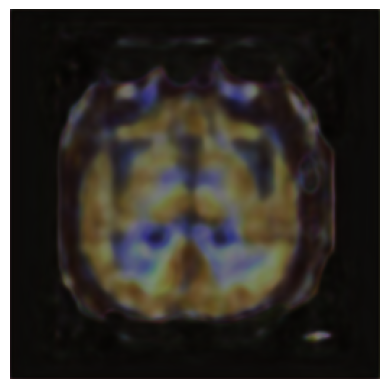

Epoch 1/1000, Loss: 3.8578
Epoch 2/1000, Loss: 3.8470
Epoch 3/1000, Loss: 3.8373
Epoch 4/1000, Loss: 3.8281
Epoch 5/1000, Loss: 3.8196
Epoch 6/1000, Loss: 3.8108
Epoch 7/1000, Loss: 3.8027
Epoch 8/1000, Loss: 3.7945
Epoch 9/1000, Loss: 3.7870
Epoch 10/1000, Loss: 3.7794
Epoch 11/1000, Loss: 3.7719
Epoch 12/1000, Loss: 3.7647
Epoch 13/1000, Loss: 3.7577
Epoch 14/1000, Loss: 3.7508
Epoch 15/1000, Loss: 3.7441
Epoch 16/1000, Loss: 3.7375
Epoch 17/1000, Loss: 3.7311
Epoch 18/1000, Loss: 3.7247
Epoch 19/1000, Loss: 3.7185
Epoch 20/1000, Loss: 3.7124
Epoch 21/1000, Loss: 3.7064
Epoch 22/1000, Loss: 3.7005
Epoch 23/1000, Loss: 3.6947
Epoch 24/1000, Loss: 3.6890
Epoch 25/1000, Loss: 3.6835
Epoch 26/1000, Loss: 3.6780
Epoch 27/1000, Loss: 3.6727
Epoch 28/1000, Loss: 3.6674
Epoch 29/1000, Loss: 3.6623
Epoch 30/1000, Loss: 3.6572
Epoch 31/1000, Loss: 3.6522
Epoch 32/1000, Loss: 3.6473
Epoch 33/1000, Loss: 3.6426
Epoch 34/1000, Loss: 3.6378
Epoch 35/1000, Loss: 3.6331
Epoch 36/1000, Loss: 3.6285
E

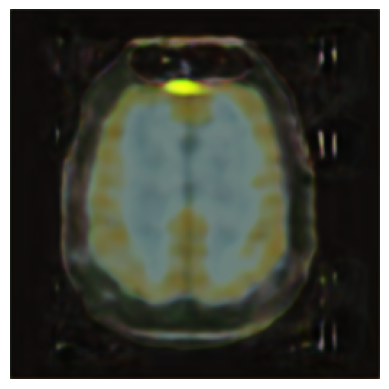

Epoch 1/1000, Loss: 4.2130
Epoch 2/1000, Loss: 4.2023
Epoch 3/1000, Loss: 4.1923
Epoch 4/1000, Loss: 4.1825
Epoch 5/1000, Loss: 4.1731
Epoch 6/1000, Loss: 4.1643
Epoch 7/1000, Loss: 4.1553
Epoch 8/1000, Loss: 4.1464
Epoch 9/1000, Loss: 4.1380
Epoch 10/1000, Loss: 4.1302
Epoch 11/1000, Loss: 4.1221
Epoch 12/1000, Loss: 4.1147
Epoch 13/1000, Loss: 4.1073
Epoch 14/1000, Loss: 4.1001
Epoch 15/1000, Loss: 4.0931
Epoch 16/1000, Loss: 4.0862
Epoch 17/1000, Loss: 4.0796
Epoch 18/1000, Loss: 4.0731
Epoch 19/1000, Loss: 4.0667
Epoch 20/1000, Loss: 4.0604
Epoch 21/1000, Loss: 4.0542
Epoch 22/1000, Loss: 4.0481
Epoch 23/1000, Loss: 4.0421
Epoch 24/1000, Loss: 4.0361
Epoch 25/1000, Loss: 4.0303
Epoch 26/1000, Loss: 4.0244
Epoch 27/1000, Loss: 4.0187
Epoch 28/1000, Loss: 4.0130
Epoch 29/1000, Loss: 4.0075
Epoch 30/1000, Loss: 4.0018
Epoch 31/1000, Loss: 3.9965
Epoch 32/1000, Loss: 3.9910
Epoch 33/1000, Loss: 3.9856
Epoch 34/1000, Loss: 3.9805
Epoch 35/1000, Loss: 3.9752
Epoch 36/1000, Loss: 3.9700
E

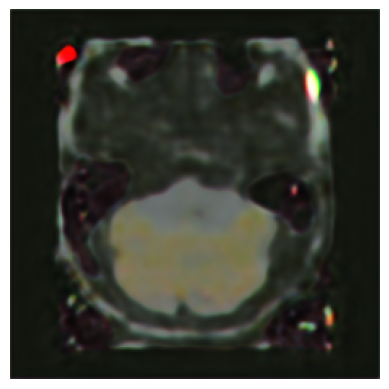

Epoch 1/1000, Loss: 3.7512
Epoch 2/1000, Loss: 3.7400
Epoch 3/1000, Loss: 3.7302
Epoch 4/1000, Loss: 3.7205
Epoch 5/1000, Loss: 3.7111
Epoch 6/1000, Loss: 3.7022
Epoch 7/1000, Loss: 3.6939
Epoch 8/1000, Loss: 3.6859
Epoch 9/1000, Loss: 3.6782
Epoch 10/1000, Loss: 3.6709
Epoch 11/1000, Loss: 3.6638
Epoch 12/1000, Loss: 3.6569
Epoch 13/1000, Loss: 3.6502
Epoch 14/1000, Loss: 3.6437
Epoch 15/1000, Loss: 3.6374
Epoch 16/1000, Loss: 3.6311
Epoch 17/1000, Loss: 3.6249
Epoch 18/1000, Loss: 3.6188
Epoch 19/1000, Loss: 3.6128
Epoch 20/1000, Loss: 3.6068
Epoch 21/1000, Loss: 3.6009
Epoch 22/1000, Loss: 3.5950
Epoch 23/1000, Loss: 3.5893
Epoch 24/1000, Loss: 3.5836
Epoch 25/1000, Loss: 3.5779
Epoch 26/1000, Loss: 3.5723
Epoch 27/1000, Loss: 3.5669
Epoch 28/1000, Loss: 3.5614
Epoch 29/1000, Loss: 3.5561
Epoch 30/1000, Loss: 3.5509
Epoch 31/1000, Loss: 3.5457
Epoch 32/1000, Loss: 3.5407
Epoch 33/1000, Loss: 3.5357
Epoch 34/1000, Loss: 3.5308
Epoch 35/1000, Loss: 3.5260
Epoch 36/1000, Loss: 3.5213
E

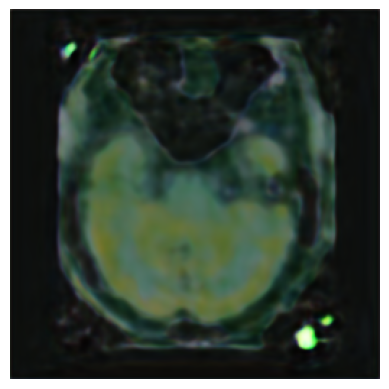

Epoch 1/1000, Loss: 3.5620
Epoch 2/1000, Loss: 3.5513
Epoch 3/1000, Loss: 3.5415
Epoch 4/1000, Loss: 3.5319
Epoch 5/1000, Loss: 3.5228
Epoch 6/1000, Loss: 3.5141
Epoch 7/1000, Loss: 3.5057
Epoch 8/1000, Loss: 3.4979
Epoch 9/1000, Loss: 3.4903
Epoch 10/1000, Loss: 3.4831
Epoch 11/1000, Loss: 3.4763
Epoch 12/1000, Loss: 3.4696
Epoch 13/1000, Loss: 3.4630
Epoch 14/1000, Loss: 3.4563
Epoch 15/1000, Loss: 3.4497
Epoch 16/1000, Loss: 3.4433
Epoch 17/1000, Loss: 3.4370
Epoch 18/1000, Loss: 3.4308
Epoch 19/1000, Loss: 3.4250
Epoch 20/1000, Loss: 3.4190
Epoch 21/1000, Loss: 3.4135
Epoch 22/1000, Loss: 3.4080
Epoch 23/1000, Loss: 3.4024
Epoch 24/1000, Loss: 3.3971
Epoch 25/1000, Loss: 3.3919
Epoch 26/1000, Loss: 3.3870
Epoch 27/1000, Loss: 3.3819
Epoch 28/1000, Loss: 3.3770
Epoch 29/1000, Loss: 3.3723
Epoch 30/1000, Loss: 3.3676
Epoch 31/1000, Loss: 3.3632
Epoch 32/1000, Loss: 3.3587
Epoch 33/1000, Loss: 3.3543
Epoch 34/1000, Loss: 3.3500
Epoch 35/1000, Loss: 3.3458
Epoch 36/1000, Loss: 3.3416
E

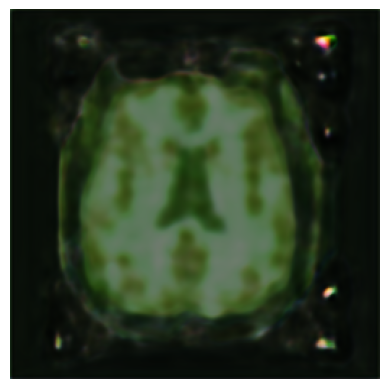

Epoch 1/1000, Loss: 3.6567
Epoch 2/1000, Loss: 3.6407
Epoch 3/1000, Loss: 3.6269
Epoch 4/1000, Loss: 3.6145
Epoch 5/1000, Loss: 3.6020
Epoch 6/1000, Loss: 3.5904
Epoch 7/1000, Loss: 3.5789
Epoch 8/1000, Loss: 3.5682
Epoch 9/1000, Loss: 3.5582
Epoch 10/1000, Loss: 3.5489
Epoch 11/1000, Loss: 3.5399
Epoch 12/1000, Loss: 3.5314
Epoch 13/1000, Loss: 3.5231
Epoch 14/1000, Loss: 3.5152
Epoch 15/1000, Loss: 3.5074
Epoch 16/1000, Loss: 3.4999
Epoch 17/1000, Loss: 3.4925
Epoch 18/1000, Loss: 3.4854
Epoch 19/1000, Loss: 3.4783
Epoch 20/1000, Loss: 3.4714
Epoch 21/1000, Loss: 3.4647
Epoch 22/1000, Loss: 3.4579
Epoch 23/1000, Loss: 3.4513
Epoch 24/1000, Loss: 3.4449
Epoch 25/1000, Loss: 3.4386
Epoch 26/1000, Loss: 3.4322
Epoch 27/1000, Loss: 3.4261
Epoch 28/1000, Loss: 3.4199
Epoch 29/1000, Loss: 3.4136
Epoch 30/1000, Loss: 3.4077
Epoch 31/1000, Loss: 3.4017
Epoch 32/1000, Loss: 3.3957
Epoch 33/1000, Loss: 3.3899
Epoch 34/1000, Loss: 3.3841
Epoch 35/1000, Loss: 3.3785
Epoch 36/1000, Loss: 3.3728
E

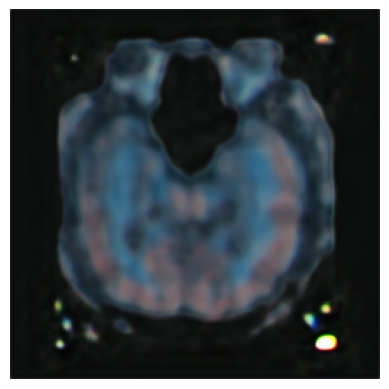

KeyboardInterrupt: 

In [32]:
def find_png_pairs(folder_path):
    all_files = os.listdir(folder_path)

    files_with_1 = [f for f in all_files if f.endswith(".png") and "(2)" in f]
    files_with_2 = [f for f in all_files if f.endswith(".png") and "(3)" in f]

    file_pairs = []

    for file_1 in files_with_1:
        prefix = file_1.replace(" (2)", "")
        for file_2 in files_with_2:
            if file_2.replace(" (3)", "") == prefix:
                file_1_path = os.path.join(folder_path, prefix)
                file_2_path = os.path.join(folder_path, file_2)
                file_pairs.append((file_1_path, file_2_path))

    return file_pairs


# folder_path = "data/test_for_final"
# png_pairs = find_png_pairs(folder_path)
# num_epoch = 500
# max_iter = 2000
# learning_rate = 1e-6
# lbda = 20.0
# mu = 1.0
# tol = 1e-7

folder_path = "data/test_for_final"
png_pairs = find_png_pairs(folder_path)
num_epoch = 1000
max_iter = 1000
learning_rate = 1e-5
lbda = 20.0
mu = 1.0
tol = 1e-7

for pair in png_pairs:
    path1 = pair[0]
    path2 = pair[1]
    start_time = time.time()
    # Process image for decompositions
    Z1, L1, E1 = process_and_save_image(
        path=path1,
        grayscale=False,
        output_dir="data/test_for_final/temp_decomposition",
        lambda_=lbda,
        mu=mu,
        max_iter=max_iter,
        tol=tol,
    )
    end_time1 = time.time()

    Z2, L2, E2 = process_and_save_image(
        path=path2,
        grayscale=False,
        output_dir="data/test_for_final/temp_decomposition",
        lambda_=lbda,
        mu=mu,
        max_iter=max_iter,
        tol=tol,
    )
    end_time2 = time.time()
    save_results_Z(
        path2,
        Z2,
        L2,
        E2,
        output_dir="data/test_for_final/temp",
        lambda_=lbda,
        mu=mu,
        max_iter=max_iter,
        tol=tol,
    )

    save_results_Z(
        path1,
        Z1,
        L1,
        E1,
        output_dir="data/test_for_final/temp",
        lambda_=lbda,
        mu=mu,
        max_iter=max_iter,
        tol=tol,
    )
    # Get the decomposed results and fuse the principal one

    output_image = fusion_model(
        folder_path="data/test_for_final/temp/",
        num_epochs=num_epoch,
        learning_rate=learning_rate,
    )

    end_time3 = time.time()
    delete_all_files_in_folder("data/test_for_final/temp/")

    file_name_without_extension = os.path.splitext(os.path.basename(path1))[0]
    output_folder = "data/test_for_final/output_fused"
    filename = f"{file_name_without_extension}_output_image_epochs_{num_epoch}_lr_{learning_rate}.png"
    plt.imshow(output_image)
    plt.axis("off")
    filepath = os.path.join(output_folder, filename)
    plt.savefig(filepath, bbox_inches="tight", pad_inches=0)
    plt.close()
    times = [start_time, end_time1, end_time2, end_time3]
    times_filename = f"{file_name_without_extension}_times.txt"
    times_filepath = os.path.join(output_folder, times_filename)
    with open(times_filepath, "w") as f:
        f.write(f"Start Time: {times[0]}\n")
        f.write(f"End Time 1: {times[1]}\n")
        f.write(f"End Time 2: {times[2]}\n")
        f.write(f"End Time 3: {times[3]}\n")

    # Fuse the saliency one and then fused the final resutls

# Model image

In [34]:
def get_numeric_prefix(filename):
    match = re.match(r"(\d+)", filename)
    return match.group(1) if match else None


def find_images_with_prefix_and_suffix(folder_path, prefix, adfix):
    if not os.path.isdir(folder_path):
        raise FileNotFoundError(f"The folder {folder_path} does not exist.")
    matched_images = []
    for filename in os.listdir(folder_path):
        if filename.endswith(".png"):
            if filename.startswith(prefix) and filename.endswith(adfix + ".png"):
                file_path = os.path.join(folder_path, filename)
                img = load_image(file_path, grayscale=False)
                matched_images.append(img)

    return matched_images


def load_image(path, grayscale=True):
    if grayscale:
        img = cv2.imread(path, cv2.IMREAD_GRAYSCALE)
    else:
        img = cv2.imread(path, cv2.IMREAD_COLOR)
    img = img.astype(np.double) / 255.0  # 归一化
    return img


# Read 10 images fused
folder_path = "data/test_for_final/output_fused"
image_files = [
    os.path.join(folder_path, f) for f in os.listdir(folder_path) if f.endswith(".png")
]

image_idx = [
    get_numeric_prefix(f) for f in os.listdir(folder_path) if f.endswith(".png")
]
image_list = [load_image(img_file, grayscale=False) for img_file in image_files]

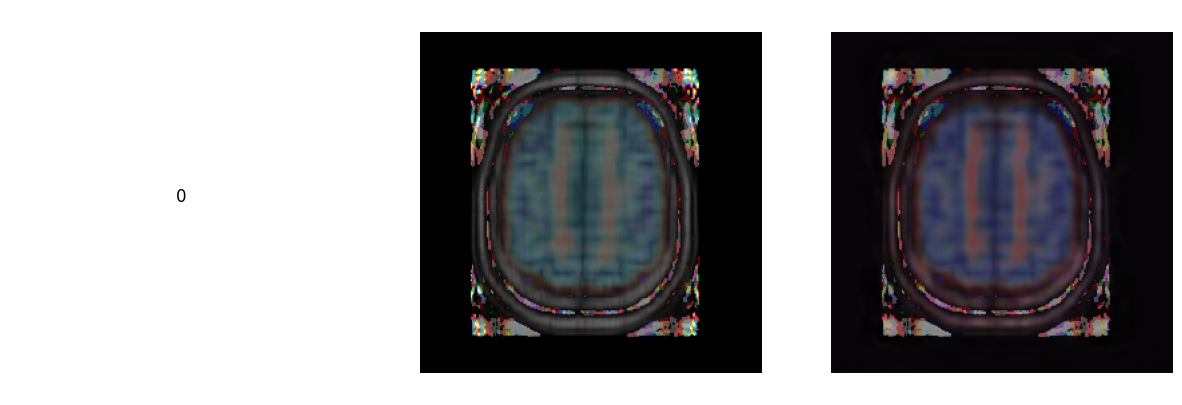

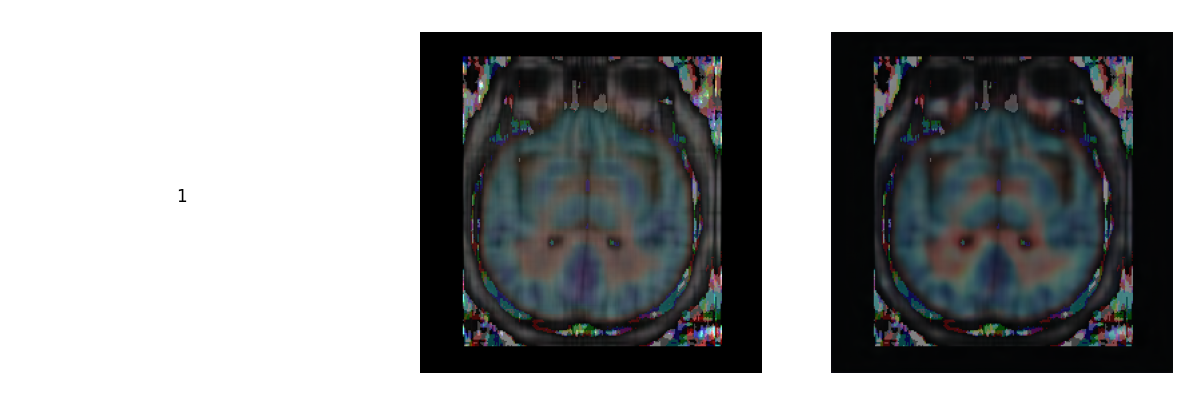

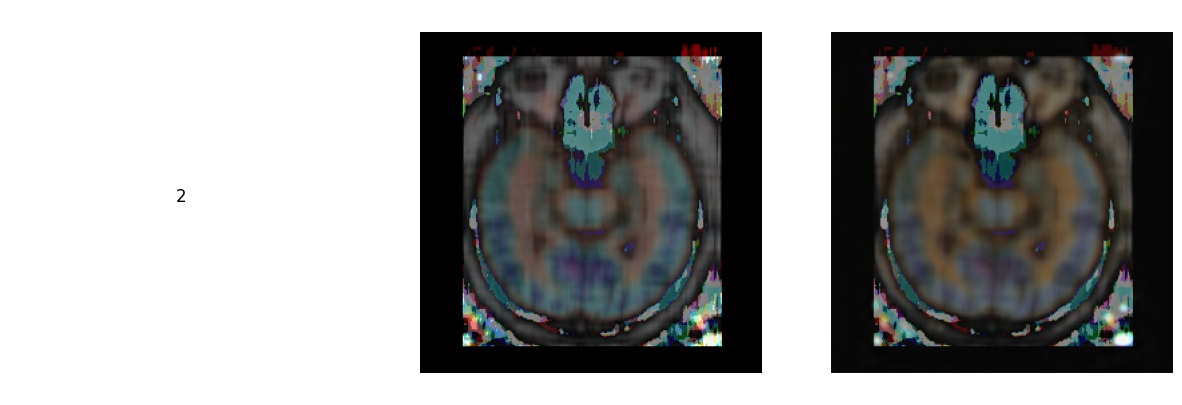

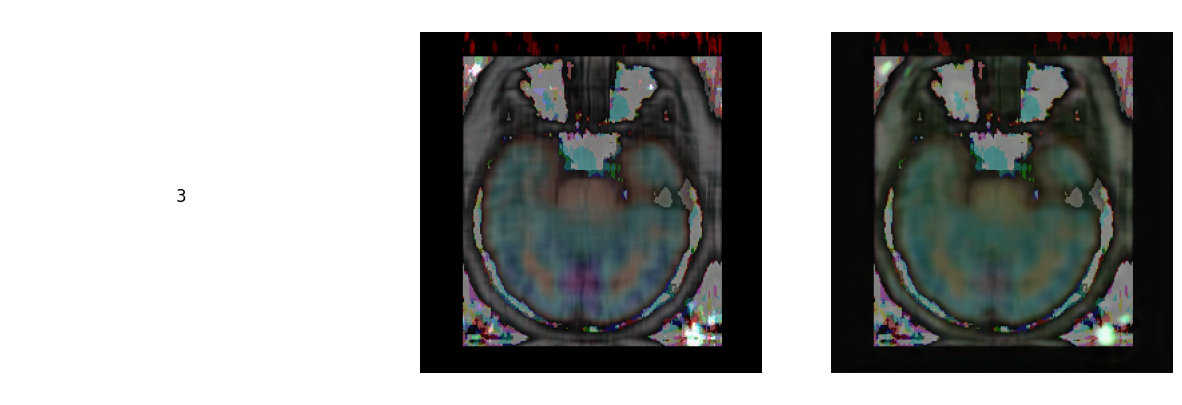

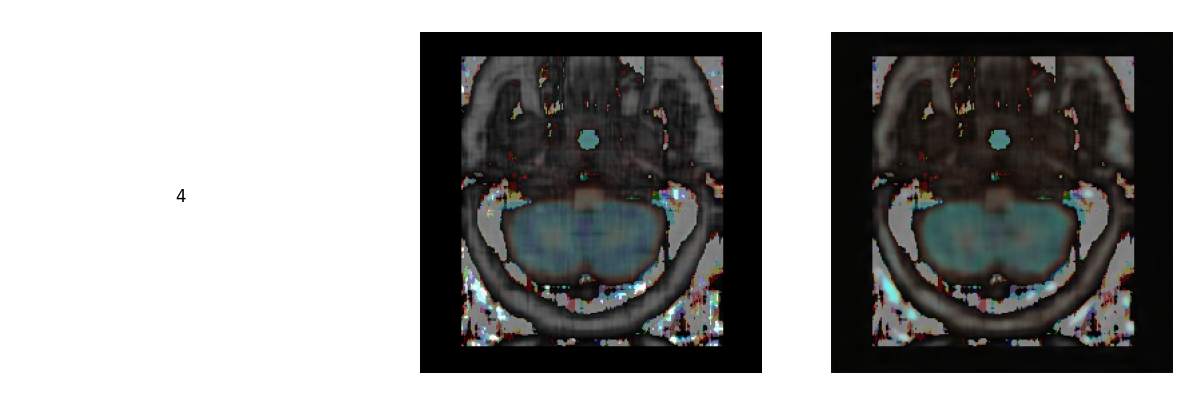

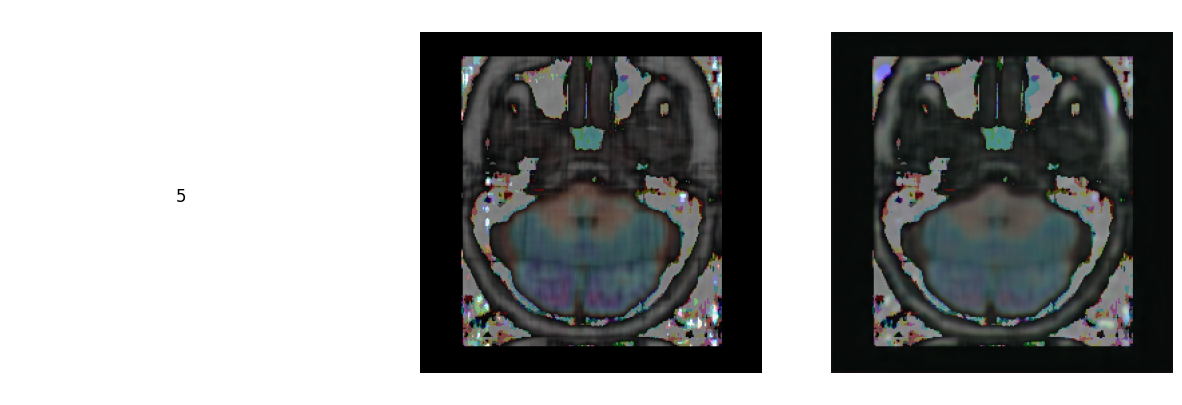

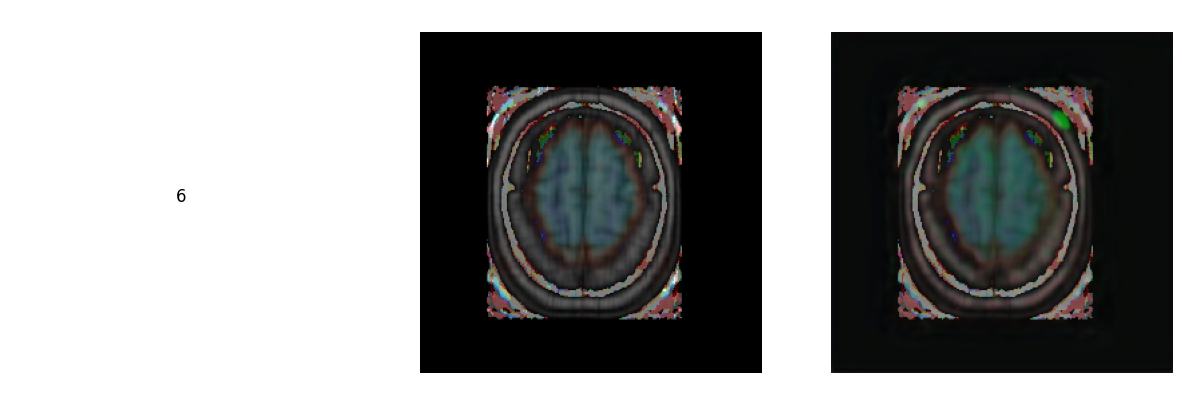

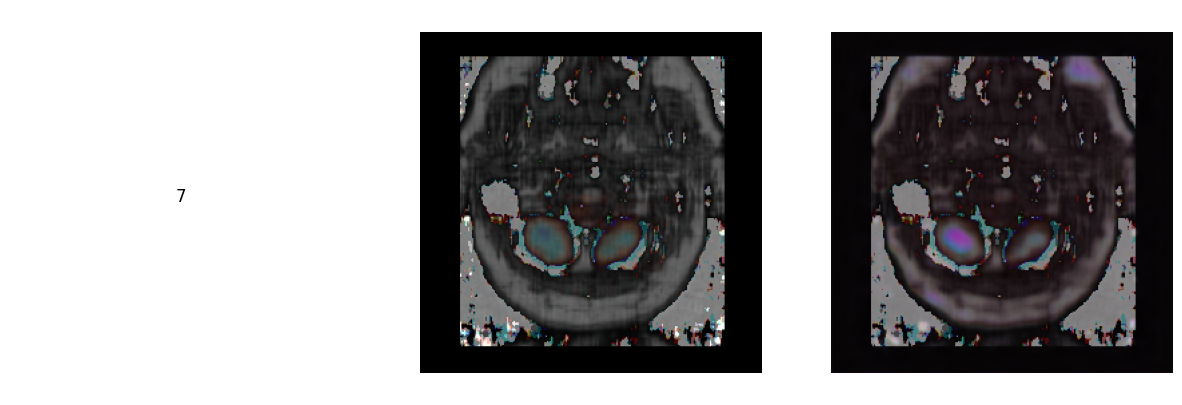

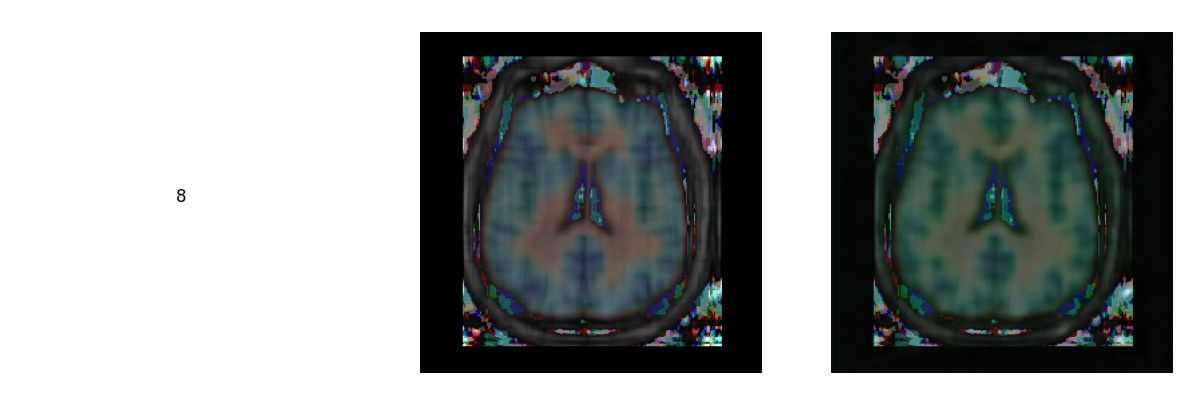

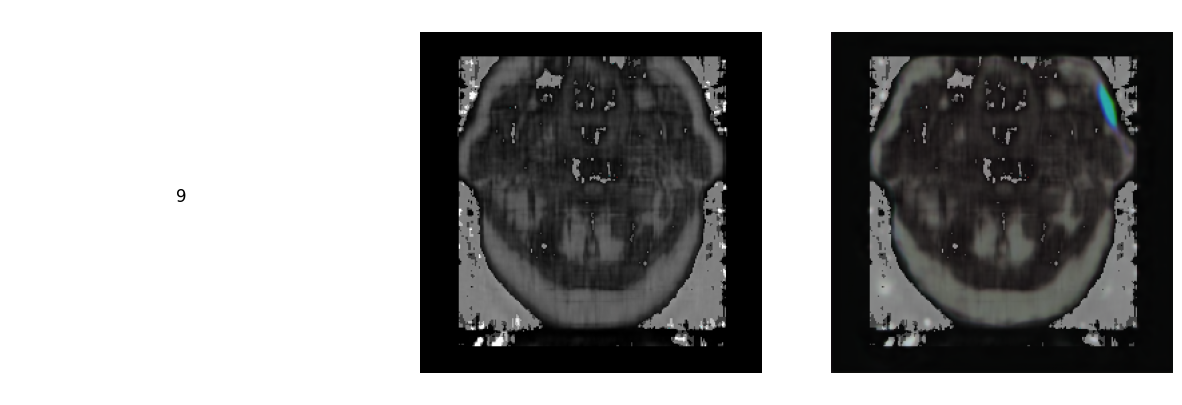

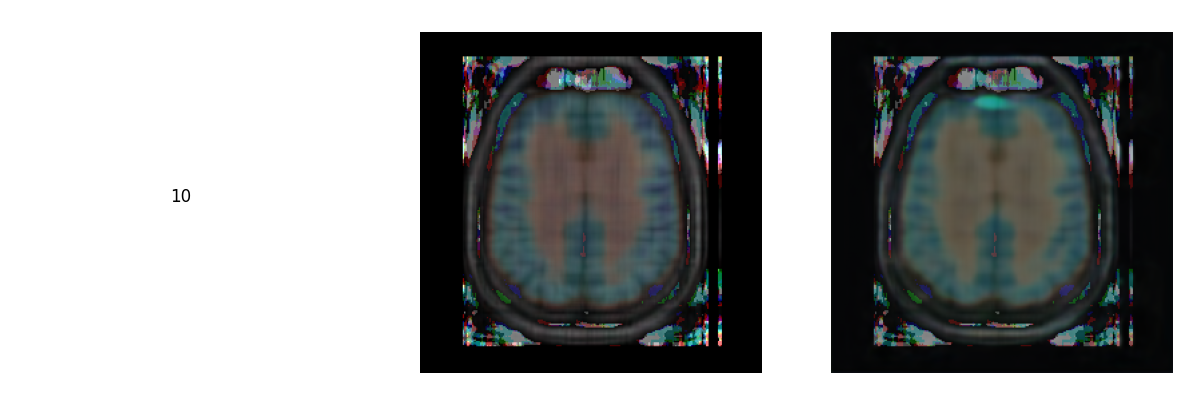

In [37]:
import matplotlib.pyplot as plt


def resize_and_ensure_channels(image, target_size=(256, 256)):
    """Resize image to target size and ensure it has 3 channels"""
    if len(image.shape) == 2:  # Grayscale image
        image = cv2.cvtColor(image, cv2.COLOR_GRAY2BGR)
    elif image.shape[2] != 3:  # Not 3 channels
        raise ValueError("Image must have 3 color channels")
    # Resize the image
    return cv2.resize(image, target_size)


for index, img in enumerate(image_list):
    # print(index)
    # print(image_idx[index])
    # plt.imshow(img)
    # plt.axis("off")
    # plt.show()
    img_fused_Z = resize_and_ensure_channels(img)
    img_Z = find_images_with_prefix_and_suffix(
        "data/test_for_final/temp_decomposition", f"{image_idx[index]}_Z", "1e-07"
    )[0]

    img_Z_3 = find_images_with_prefix_and_suffix(
        "data/test_for_final/temp_decomposition", f"{image_idx[index]} (3)_Z", "1e-07"
    )[0]

    img_L = find_images_with_prefix_and_suffix(
        "data/test_for_final/temp_decomposition", f"{image_idx[index]}_L", "1e-07"
    )[0]
    img_L_3 = find_images_with_prefix_and_suffix(
        "data/test_for_final/temp_decomposition", f"{image_idx[index]} (3)_L", "1e-07"
    )[0]

    # Directly Fusion using SUM
    fusion_direct = ((img_Z + img_Z_3) / 2 + (img_L + img_L_3) / 2) / 2
    fusion_CNN = (img_fused_Z + +(img_L + img_L_3) / 2) / 2

    num_images = 2
    fig, axes = plt.subplots(
        1, num_images + 1, figsize=(15, 5)
    )  # 1 行 num_images + 1 列

    # axes[0].text(0.5, 0.5, str(index), fontsize=12, ha="center")
    # axes[0].axis("off")
    # axes[1].imshow(fusion_direct)
    # axes[1].axis("off")
    # axes[2].imshow(fusion_CNN)
    # axes[2].axis("off")

In [32]:
img_fused_Z.shape

(369, 369)